In [1072]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import pyodbc
import re
import matplotlib.pyplot as plt

In [1073]:
df_1 = pd.read_csv('affiliates.csv',sep=';')
df_2 = pd.read_csv('affiliate_orders.csv',sep=',')

In [1074]:
df_1.head()

,id,created_at,traffic_amount
0,151,2014-08-22 20:04:38.223152,1434704
1,3792,2020-03-19 11:22:41.411688,653855
2,2513,2018-10-03 16:51:52.393059,381085
3,2704,2019-03-13 16:12:12.506301,360855
4,3340,2019-06-06 16:25:01.741799,180385


In [1075]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4321 entries, 0 to 4320
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              4321 non-null   int64 
 1   created_at      4321 non-null   object
 2   traffic_amount  4321 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 101.4+ KB


In [1076]:
df_1['created_at'] = pd.to_datetime(df_1['created_at']).dt.normalize()

In [1077]:
df_2.head()

,id,affiliate_id,created_at,state
0,1908655,1,2023-06-09 14:57:51.895548,canceled
1,1982469,1,2023-06-26 15:35:06.922044,held
2,1491902,1,2022-11-05 17:22:29.533635,held
3,1235697,1,2022-07-27 13:54:22.133388,canceled
4,1235831,1,2022-07-27 14:21:33.350998,held


In [1078]:
df_2['id'].value_counts(ascending=False) # было интересно может ли быть, что просто хранятся статусы заказов, а не обновляется

1908655    1
1409178    1
1513426    1
1405313    1
1405389    1
          ..
1846169    1
1131122    1
1153352    1
1143317    1
1945955    1
Name: id, Length: 257914, dtype: int64

In [1079]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257914 entries, 0 to 257913
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            257914 non-null  int64 
 1   affiliate_id  257914 non-null  int64 
 2   created_at    257914 non-null  object
 3   state         257914 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.9+ MB


In [1080]:
df_2['created_at'] = pd.to_datetime(df_2['created_at']).dt.normalize()

In [1081]:
df_1['id'].nunique()


4321

В данном случае эффективность можно оценить только метрикой выполненные заказы/общее число переходов


In [1082]:
df_3 = df_2.merge(df_1,left_on="affiliate_id",right_on="id")
df_3

,id_x,affiliate_id,created_at_x,state,id_y,created_at_y,traffic_amount
0,1908655,1,2023-06-09,canceled,1,2013-08-14,105208
1,1982469,1,2023-06-26,held,1,2013-08-14,105208
2,1491902,1,2022-11-05,held,1,2013-08-14,105208
3,1235697,1,2022-07-27,canceled,1,2013-08-14,105208
4,1235831,1,2022-07-27,held,1,2013-08-14,105208
...,...,...,...,...,...,...,...
257909,1969529,5084,2023-06-23,held,5084,2023-06-16,246
257910,1956651,5084,2023-06-20,held,5084,2023-06-16,246
257911,1979590,5084,2023-06-25,canceled,5084,2023-06-16,246
257912,1989282,5098,2023-06-28,held,5098,2023-06-27,46


In [1083]:
df_3.drop(['id_y'], axis=1,inplace=True)

In [1084]:
df_3.rename(columns={'created_at_x':'created_data_order','created_at_y':'created_relationship'},inplace=True)
df_3 = df_3[df_3['created_data_order']>'2023-01-01'] # взял данные за последние 6 месяцев

In [1085]:
df_3 = df_3[['affiliate_id','state','traffic_amount']].groupby(['affiliate_id','state']).agg({'state':['count'],'traffic_amount':['mean']}).reset_index()
df_3

affiliate_id     state       traffic_amount
                           count           mean
0              1  canceled  1597       105208.0
1              1      held  2133       105208.0
2              1   pending   376       105208.0
3              9  canceled     7          113.0
4              9      held    18          113.0
..           ...       ...   ...            ...
326         5084  canceled     6          246.0
327         5084      held     3          246.0
328         5084   pending     2          246.0
329         5098      held     1           46.0
330         5102   pending     1            0.0

[331 rows x 4 columns]

In [1086]:
df_3.columns = ['affiliate_id','state','state_amount','traffic_amount']
df_3['conversion'] = round(df_3['state_amount']/df_3['traffic_amount'],3)*100
df_3.head()


,affiliate_id,state,state_amount,traffic_amount,conversion
0,1,canceled,1597,105208.0,1.5
1,1,held,2133,105208.0,2.0
2,1,pending,376,105208.0,0.4
3,9,canceled,7,113.0,6.2
4,9,held,18,113.0,15.9


In [1087]:
df_3.sort_values(by=['conversion'],ascending=False)

,affiliate_id,state,state_amount,traffic_amount,conversion
330,5102,pending,1,0.0,inf
186,3618,pending,1,0.0,inf
103,1683,canceled,570,0.0,inf
185,3618,held,5425,0.0,inf
184,3618,canceled,2859,0.0,inf
...,...,...,...,...,...
77,1208,canceled,6,53630.0,0.0
147,2704,canceled,3,360855.0,0.0
148,2704,held,1,360855.0,0.0
78,1208,held,7,53630.0,0.0


Увидели, что есть данные, где траффик = 0. Для

In [1088]:
df_zero_traffic = df_3[df_3['traffic_amount']==0]

In [1089]:
df_zero_traffic['affiliate_id'].unique()

array([1683, 3618, 5102], dtype=int64)

In [1090]:
df_3 = df_3[df_3['traffic_amount']!=0]
df_3_held = df_3[df_3['state']=='held'].sort_values(by=['conversion'],ascending=False)
df_3_held.sort_values(by=['conversion','traffic_amount'],ascending=False)

,affiliate_id,state,state_amount,traffic_amount,conversion
198,3801,held,2,2.0,100.0
312,4907,held,1,1.0,100.0
17,216,held,1,3.0,33.3
269,4590,held,4,18.0,22.2
296,4800,held,1,6.0,16.7
...,...,...,...,...,...
247,4433,held,2,1662.0,0.1
208,3965,held,1,1584.0,0.1
148,2704,held,1,360855.0,0.0
78,1208,held,7,53630.0,0.0


Отфильтруем тех партнеров, которые привели более 100 трафика


In [1091]:
df_3_held[df_3_held['traffic_amount']>100].sort_values(by=['conversion','traffic_amount'],ascending=False).head(15)

,affiliate_id,state,state_amount,traffic_amount,conversion
4,9,held,18,113.0,15.9
155,2781,held,692,7950.0,8.7
191,3652,held,67,840.0,8.0
177,3533,held,1669,25553.0,6.5
171,3399,held,13,213.0,6.1
126,1795,held,9,162.0,5.6
219,4084,held,17,329.0,5.2
64,1089,held,27,564.0,4.8
91,1492,held,62,1311.0,4.7
241,4333,held,297,6931.0,4.3


# Наиболее эффективные(топ 15)партнеры по показателю конверсии среди тех партнеров, которые привели более 100 трафика за последние полгода

In [1092]:
list(df_3_held[df_3_held['traffic_amount']>100].sort_values(by=['conversion','traffic_amount'],ascending=False)['affiliate_id'].head(15))

[9,
 2781,
 3652,
 3533,
 3399,
 1795,
 4084,
 1089,
 1492,
 4333,
 3599,
 2555,
 1732,
 1308,
 4782]

# Наименее эффективные те, которые привели 0 трафика. Посмотрел, что для туризма конверсия 4-7% является нормальной, тогда порог выставляем 4%


In [1093]:
list(df_zero_traffic['affiliate_id'])

[1683, 1683, 3618, 3618, 3618, 5102]

In [1094]:
list(df_3_held[df_3_held['traffic_amount']>100].sort_values(by=['conversion','traffic_amount'],ascending=False)['affiliate_id'].tail(15))

[2431,
 1022,
 4130,
 3340,
 1712,
 2514,
 4669,
 1762,
 3792,
 4504,
 4433,
 3965,
 2704,
 1208,
 2355]

# Нужно улучшать работу с теми 15, которые наиболее эффективно показали себя по показателю конверсии.

# 2.Cоставить прогноз по количеству заказов суммарно со всех партнеров на август и сентябрь

In [1095]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

In [1096]:
df_predict_orders = df_2.copy()

In [1097]:
df_predict_orders['month'] = df_predict_orders['created_at'].to_numpy().astype('datetime64[M]')

In [1098]:
df_predict_orders

,id,affiliate_id,created_at,state,month
0,1908655,1,2023-06-09,canceled,2023-06-01
1,1982469,1,2023-06-26,held,2023-06-01
2,1491902,1,2022-11-05,held,2022-11-01
3,1235697,1,2022-07-27,canceled,2022-07-01
4,1235831,1,2022-07-27,held,2022-07-01
...,...,...,...,...,...
257909,1969529,5084,2023-06-23,held,2023-06-01
257910,1956651,5084,2023-06-20,held,2023-06-01
257911,1979590,5084,2023-06-25,canceled,2023-06-01
257912,1989282,5098,2023-06-28,held,2023-06-01


In [1099]:
df_predict_orders = df_predict_orders.groupby(['month','state']).agg({'id':'count'}).reset_index()
df_predict_orders.columns = ['month','state','amount']


In [1100]:
df_predict_orders_held = df_predict_orders[df_predict_orders['state']=='held']

In [1101]:
df_predict_orders_held.head()

,month,state,amount
1,2022-05-01,held,8203
4,2022-06-01,held,12696
7,2022-07-01,held,16846
10,2022-08-01,held,15470
13,2022-09-01,held,7947


In [1102]:
df_predict_orders_held['month']

1    2022-05-01
4    2022-06-01
7    2022-07-01
10   2022-08-01
13   2022-09-01
16   2022-10-01
19   2022-11-01
22   2022-12-01
25   2023-01-01
28   2023-02-01
31   2023-03-01
34   2023-04-01
37   2023-05-01
40   2023-06-01
Name: month, dtype: datetime64[ns]

<AxesSubplot:xlabel='month'>

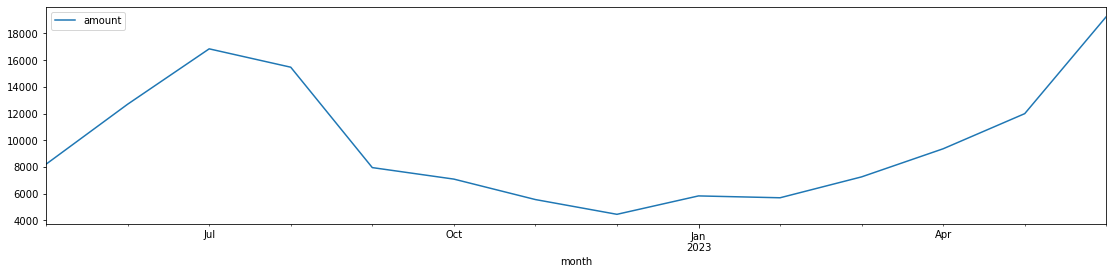

In [1103]:
y = df_predict_orders_held.set_index(['month'])
y.plot(figsize=(19,4))

 Можно предположить, что присутствует сезонность( учитывая, что мы знаем, что мы предоставляем услуги экскурсий, то в летний сезон спрос будет выше). Количество оплаченных экскурсий начинает расти с начала весны и до середины лета

In [1104]:
df_predict_orders_held['ts'] = pd.to_datetime(df_predict_orders_held['month']).dt.to_period("M")

C:\Users\Denis\AppData\Local\Temp\ipykernel_31140\1651500984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_orders_held['ts'] = pd.to_datetime(df_predict_orders_held['month']).dt.to_period("M")


In [1105]:
df_predict_orders_held

,month,state,amount,ts
1,2022-05-01,held,8203,2022-05
4,2022-06-01,held,12696,2022-06
7,2022-07-01,held,16846,2022-07
10,2022-08-01,held,15470,2022-08
13,2022-09-01,held,7947,2022-09
16,2022-10-01,held,7085,2022-10
19,2022-11-01,held,5552,2022-11
22,2022-12-01,held,4446,2022-12
25,2023-01-01,held,5825,2023-01
28,2023-02-01,held,5686,2023-02


In [1106]:
df_predict_orders_held.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 1 to 40
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   month   14 non-null     datetime64[ns]
 1   state   14 non-null     object        
 2   amount  14 non-null     int64         
 3   ts      14 non-null     period[M]     
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 560.0+ bytes


In [1107]:
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-04-01", periods=8, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
             '2023-10', '2023-11'],
            dtype='period[M]', is_relative=False)

In [1108]:
y = df_predict_orders_held[["ts","amount"]].set_index("ts")

In [1109]:
y

,amount
ts,
2022-05,8203
2022-06,12696
2022-07,16846
2022-08,15470
2022-09,7947
2022-10,7085
2022-11,5552
2022-12,4446
2023-01,5825


In [1110]:
forecaster = NaiveForecaster(strategy="last",sp=12) # sp= 12 ежемесячная сезонность
forecaster.fit(y) # обучение

NaiveForecaster(sp=12)

In [1111]:
y_pred = forecaster.predict(fh) #предсказание

In [1112]:
y_pred

,amount
2023-04,9358.0
2023-05,8203.0
2023-06,12696.0
2023-07,16846.0
2023-08,15470.0
2023-09,7947.0
2023-10,7085.0
2023-11,5552.0


In [1113]:
y

,amount
ts,
2022-05,8203
2022-06,12696
2022-07,16846
2022-08,15470
2022-09,7947
2022-10,7085
2022-11,5552
2022-12,4446
2023-01,5825


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

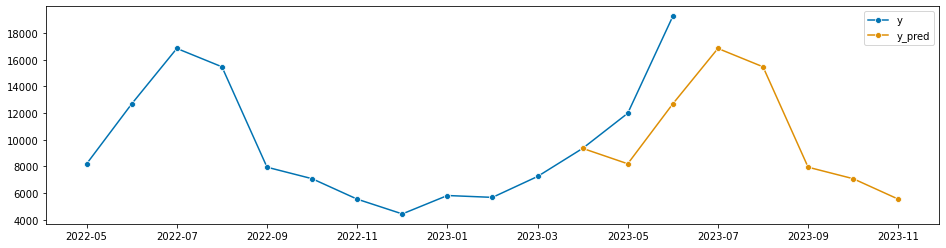

In [1114]:
plot_series(y.tail(60), y_pred, labels=["y", "y_pred"])

In [1115]:
y_train, y_test = temporal_train_test_split(y, test_size=3)

In [1116]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

In [1117]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, y_pred)

0.4238633955082643